In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Options d'affichage
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [102]:
# Charger le fichier CSV (assure-toi qu'il est bien dans le dossier data/)
data_path = "Dataa.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Le fichier {data_path} est introuvable.")

data = pd.read_csv(data_path)
print(f" Données chargées : {data.shape[0]} lignes et {data.shape[1]} colonnes.")
data.head()


 Données chargées : 1000 lignes et 9 colonnes.


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [103]:
# Aperçu global
data.info()

# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(data.isna().sum())

# Statistiques descriptives
data.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB

Valeurs manquantes :
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs  

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,970,970,970,1000,1000.000000,970.000000,1000.000000
unique,NaN,NaN,5,3,4,3,NaN,NaN,NaN
top,NaN,NaN,Clear,Medium,Morning,Bike,NaN,NaN,NaN
freq,NaN,NaN,470,390,308,503,NaN,NaN,NaN
mean,500.500000,10.059970,NaN,NaN,NaN,NaN,16.982000,4.579381,56.732000
std,288.819436,5.696656,NaN,NaN,NaN,NaN,7.204553,2.914394,22.070915
min,1.000000,0.590000,NaN,NaN,NaN,NaN,5.000000,0.000000,8.000000
25%,250.750000,5.105000,NaN,NaN,NaN,NaN,11.000000,2.000000,41.000000
50%,500.500000,10.190000,NaN,NaN,NaN,NaN,17.000000,5.000000,55.500000
75%,750.250000,15.017500,NaN,NaN,NaN,NaN,23.000000,7.000000,71.000000


In [104]:
# Gérer les valeurs manquantes
# Pour les colonnes numériques, on remplace par la moyenne
for col in ['Courier_Experience_yrs']:
    if col in data.columns and data[col].isnull().any():
        mean_val = data[col].mean()
        data[col] = data[col].fillna(mean_val)
        print(f"Valeurs manquantes dans '{col}' remplacées par la moyenne : {mean_val:.2f}")

# Pour les colonnes catégorielles, on remplace par le mode
for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    if col in data.columns and data[col].isnull().any():
        mode_val = data[col].mode()[0]
        data[col] = data[col].fillna(mode_val)
        print(f"Valeurs manquantes dans '{col}' remplacées par le mode : {mode_val}")

# Vérifier à nouveau les valeurs manquantes
print("\nNouvelles valeurs manquantes :")
print(data.isna().sum())

Valeurs manquantes dans 'Courier_Experience_yrs' remplacées par la moyenne : 4.58
Valeurs manquantes dans 'Weather' remplacées par le mode : Clear
Valeurs manquantes dans 'Traffic_Level' remplacées par le mode : Medium
Valeurs manquantes dans 'Time_of_Day' remplacées par le mode : Morning

Nouvelles valeurs manquantes :
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


In [105]:
#Vérification des colonnes, Définis la variable cible
print("Colonnes disponibles :", list(data.columns))
target = "Delivery_Time_min"
print(f" Variable cible définie : {target}")


Colonnes disponibles : ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']
 Variable cible définie : Delivery_Time_min


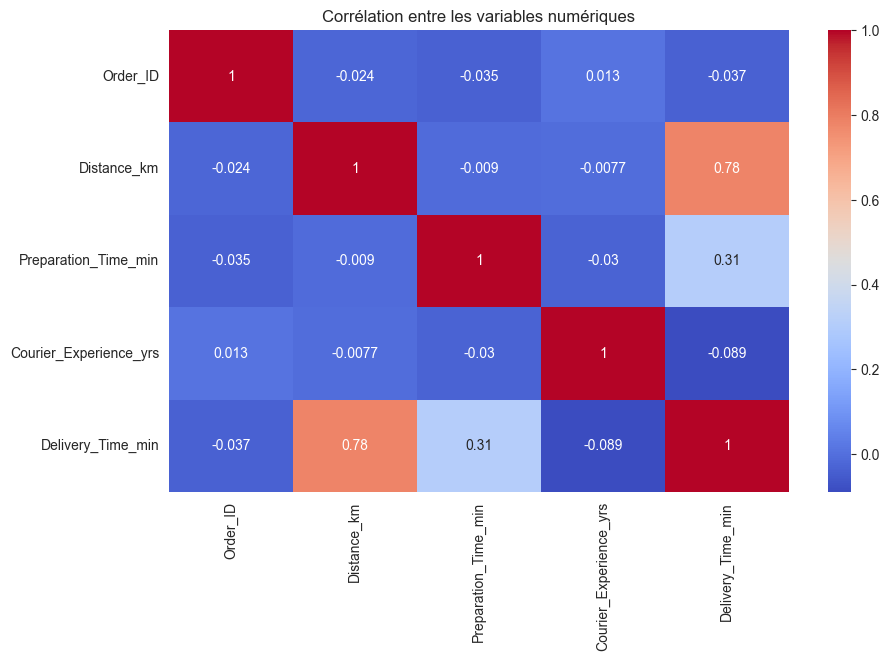

In [106]:
# Heatmap des corrélations (variables numériques)
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Corrélation entre les variables numériques")
plt.show()


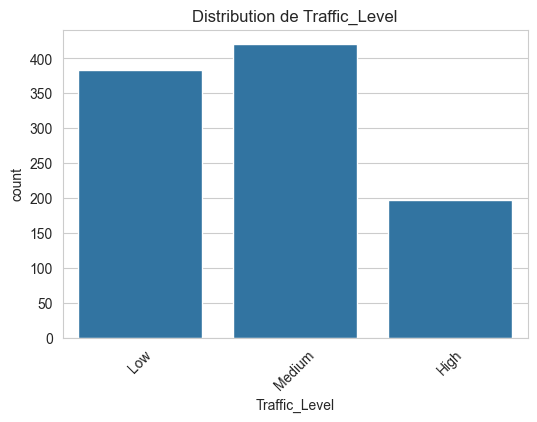

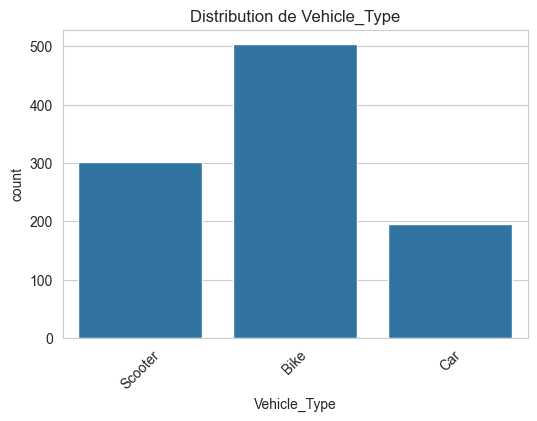

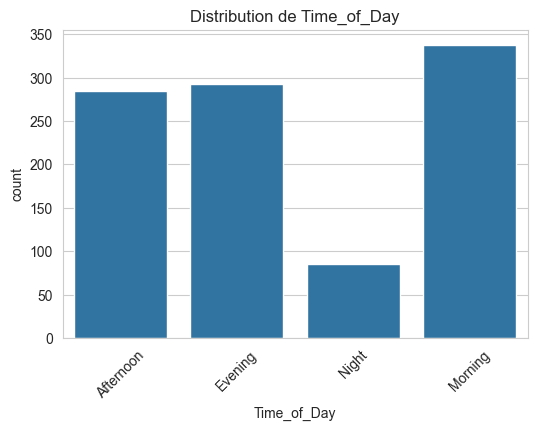

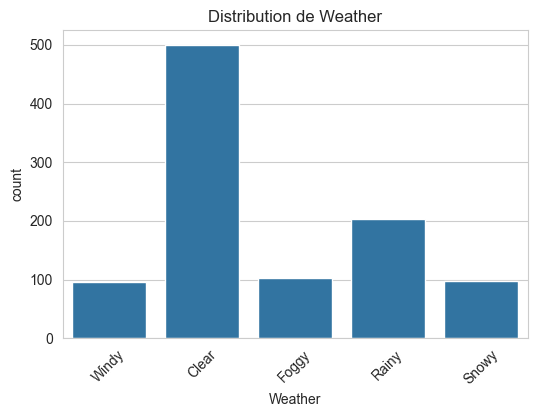

In [107]:
#Countplots (variables catégorielles)
categorical_features = ["Traffic_Level", "Vehicle_Type", "Time_of_Day", "Weather"]

for feature in categorical_features:
    if feature in data.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=feature, data=data)
        plt.title(f"Distribution de {feature}")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"⚠️ La colonne '{feature}' est absente du DataFrame.")


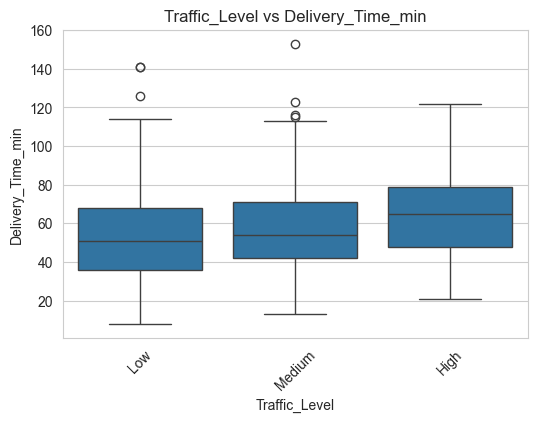

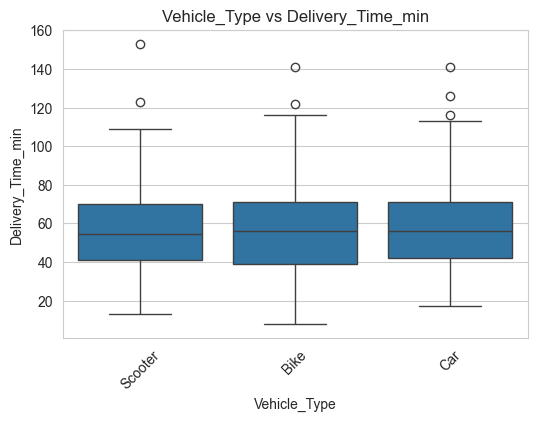

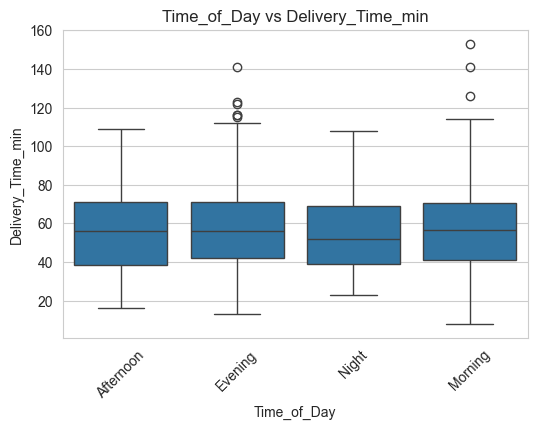

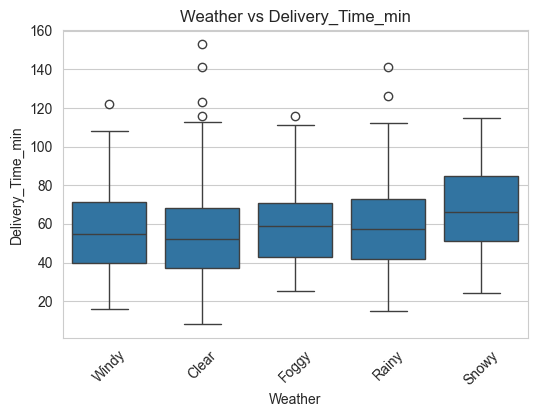

In [108]:
#Boxplots (relation entre catégorie et temps de livraison)
for feature in categorical_features:
    if feature in data.columns and target in data.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=feature, y=target, data=data)
        plt.title(f"{feature} vs {target}")
        plt.xticks(rotation=45)
        plt.show()


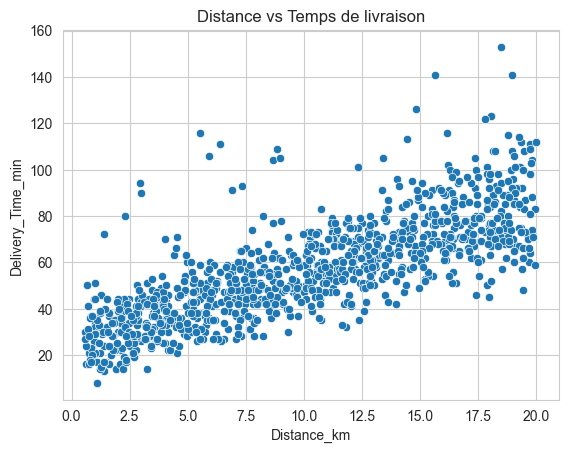

In [109]:
#Analyse rapide
# Exemple : corrélation simple entre Distance et temps de livraison
if "Distance_km" in data.columns and target in data.columns:
    sns.scatterplot(x="Distance_km", y=target, data=data)
    plt.title("Distance vs Temps de livraison")
    plt.show()


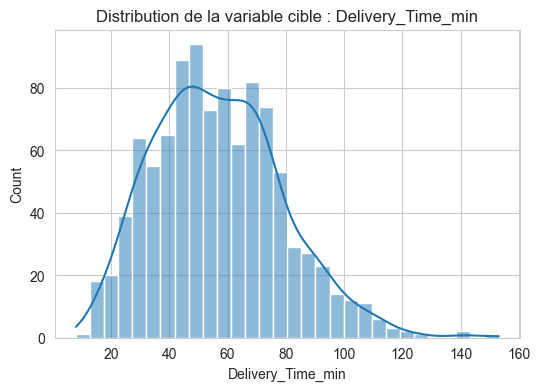

In [110]:
#Distribution de la variable cible
plt.figure(figsize=(6,4))
sns.histplot(data[target], kde=True, bins=30)
plt.title(f"Distribution de la variable cible : {target}")
plt.xlabel(target)
plt.show()


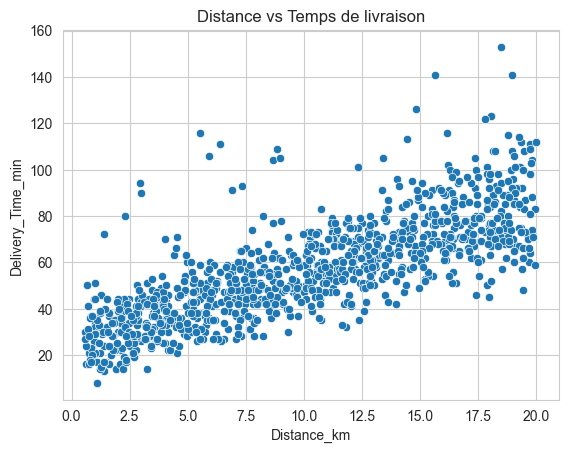

In [111]:
#Relation distance / temps de livraison
if "Distance_km" in data.columns and target in data.columns:
    sns.scatterplot(x="Distance_km", y=target, data=data)
    plt.title("Distance vs Temps de livraison")
    plt.show()


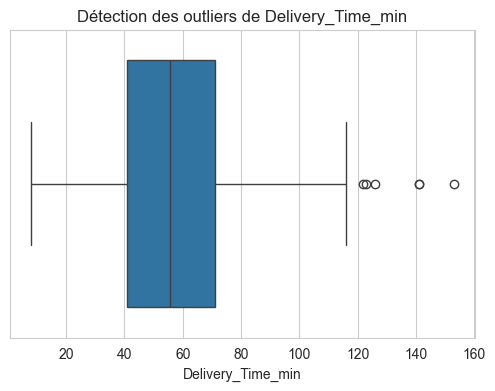

In [112]:
#Détection d’outliers (valeurs extrêmes)
plt.figure(figsize=(6,4))
sns.boxplot(x=data[target])
plt.title(f"Détection des outliers de {target}")
plt.show()


Prétraitement (StandardScaler pour numérique, OneHotEncoder pour catégoriel)

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression


df = pd.read_csv("Dataa.csv") 

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)  # categorical
    else:
        df[col].fillna(df[col].mean(), inplace=True)     # numerical




C:\Users\dickson\AppData\Local\Temp\ipykernel_28096\4045821651.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)     # numerical
C:\Users\dickson\AppData\Local\Temp\ipykernel_28096\4045821651.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [114]:
# Detect and remove outliers (IQR method)
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])



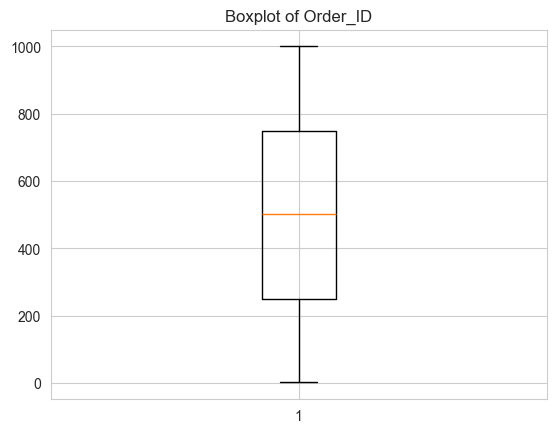

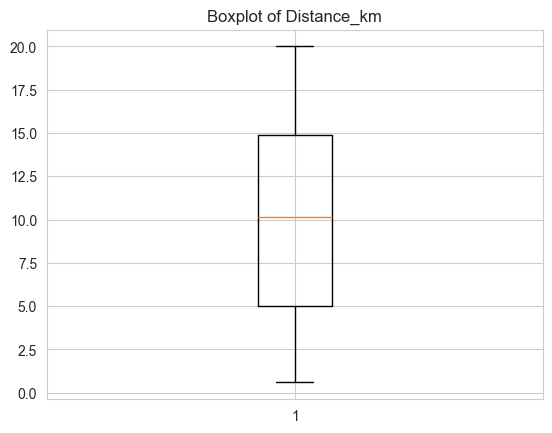

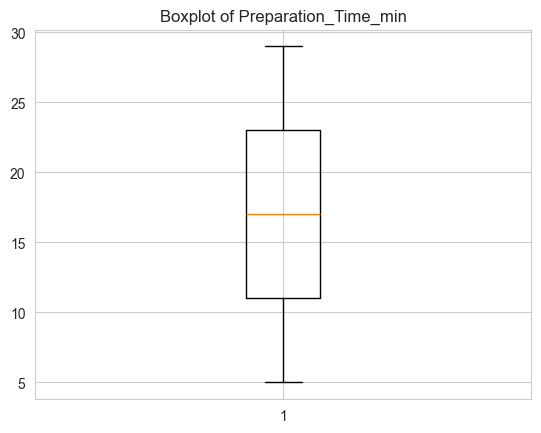

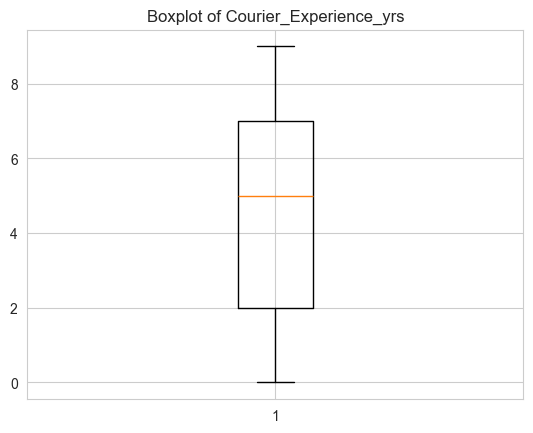

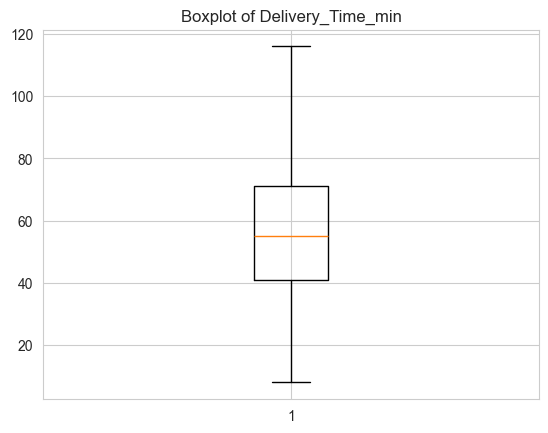

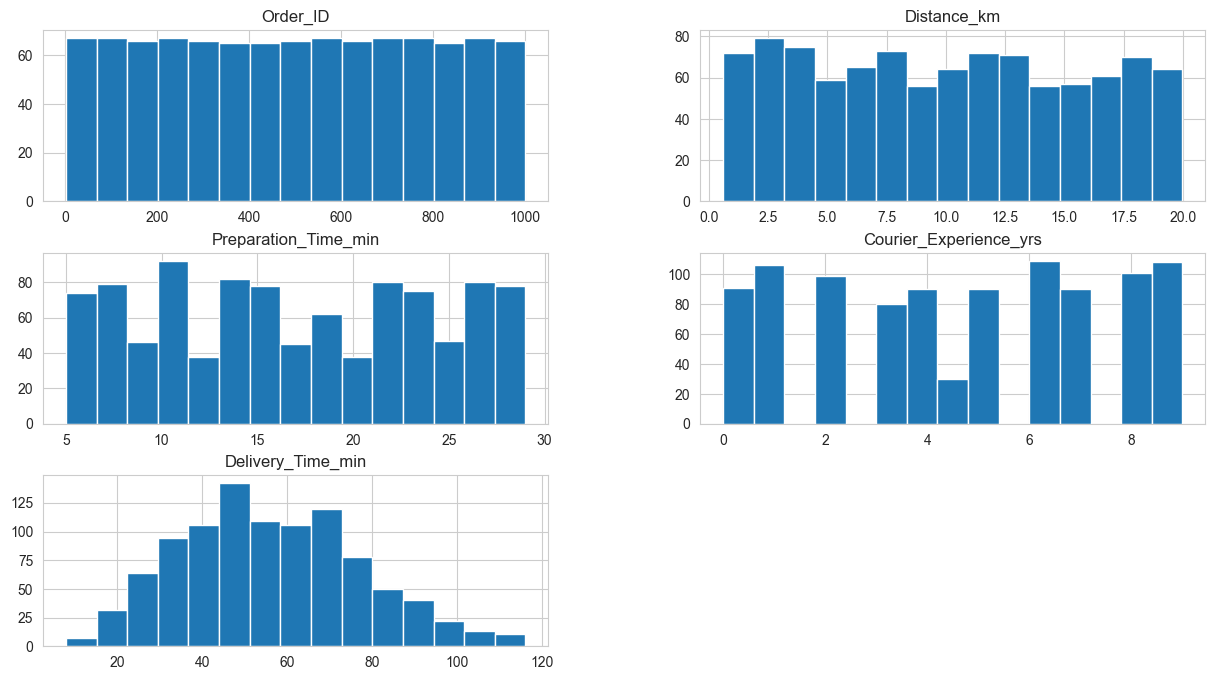

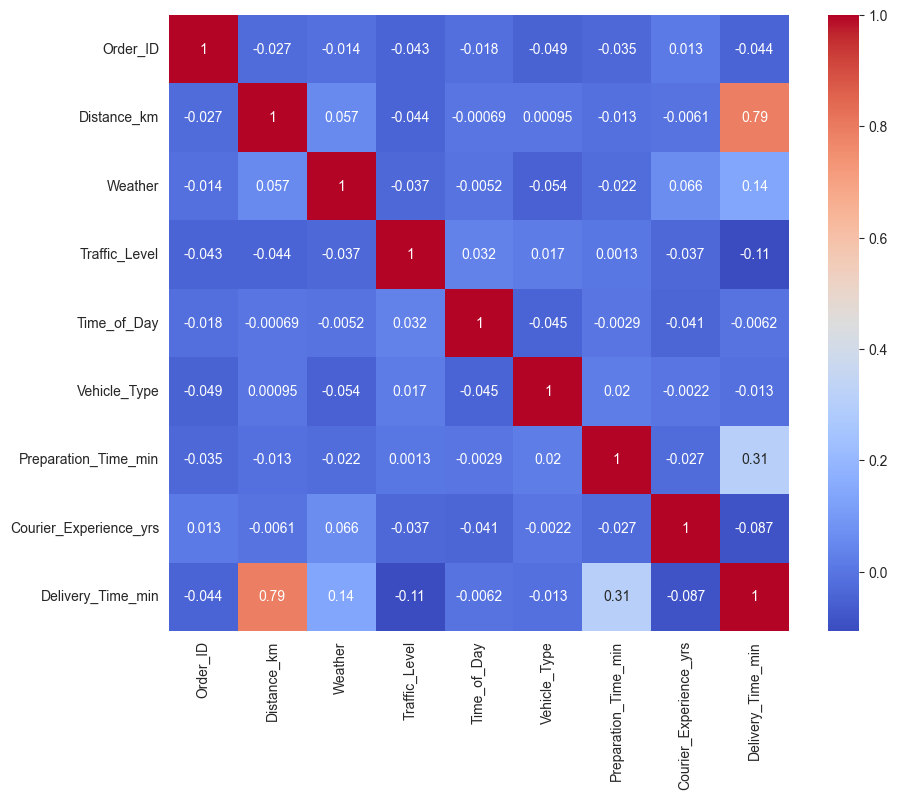

In [115]:
# Quick EDA visuals
# Boxplots for numerical columns
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Histogram of numerical columns
df[num_cols].hist(bins=15, figsize=(15,8))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()



In [116]:
# Feature selection (SelectKBest + f_regression)
# Replace 'target' with your target column name
target_col = 'Delivery_Time_min'
X = df.drop(target_col, axis=1)
y = df[target_col]

# Select top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", list(selected_features))

print("Preprocessing, EDA, and feature selection completed!")

Selected features: ['Distance_km', 'Weather', 'Traffic_Level', 'Preparation_Time_min', 'Courier_Experience_yrs']
Preprocessing, EDA, and feature selection completed!
